In [1]:
# 


In [2]:
import geopandas as gpd
import json
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
from datetime import timedelta
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
import numpy as np
import numpy as npm
import osmnx as ox
import math
import pandas as pd
from shapely.ops import snap
from tqdm import tqdm
import re

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/home/chriscarey/miniconda3/envs/mlc/lib/python3.7/site-packages/geopandas/_compat.py:53: UserWarning: The installed version of PyGEOS is too old (0.5 installed, 0.8 required), and thus GeoPandas will not use PyGEOS.
  UserWarning,


In [3]:
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

In [4]:
def peek(df):
    print(len(df))
    display(df.iloc[0:3])

In [5]:
stops_nodes_df = pd.read_csv(f'{EXPORTS_DIR}/csv/manhattan/stops_nodes.csv')
stops_nodes_df = stops_nodes_df.set_index('stop_id')
peek(stops_nodes_df)

1590


,stop_name,stop_lat,stop_lon,M1,M10,M100,M101,M102,M103,M104,...,M5,M50,M55,M57,M66,M7,M72,M8,M9,M96
stop_id,,,,,,,,,,,,,,,,,,,,,
400001,4 AV/E 10 ST,40.731342,-73.990292,POINT (-73.99037 40.73135),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400002,4 AV/E 12 ST,40.732608,-73.989958,POINT (-73.99006 40.73262),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400003,4 AV/E 13 ST,40.733936,-73.989720,POINT (-73.98985 40.73394),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
route_ids = list(stops_nodes_df.columns[3:])

In [7]:
def graph_to_node_gdf(G):
    """Converts the given graph to a GeoDataFrame of its nodes."""
    nodes, data = zip(*G.nodes(data=True))
    geom = [Point(node[0], node[1]) for node in nodes]
    nodes_gdf = gpd.GeoDataFrame(data,
                                 index=list(nodes),
                                 crs=CRS_LATLON,
                                 geometry=geom)
    return nodes_gdf

In [8]:
def graph_to_edge_gdf(G):
    """Converts the given graph to a GeoDataFrame of its edges."""
    u, v, data = zip(*G.edges(data=True))
    edges = list(zip(u, v))
    attrs = nx.get_edge_attributes(G, 'speed')
    geom = [
        LineString((Point(edge[0][0],
                          edge[0][1]), Point(edge[1][0], edge[1][1])))
        for edge in edges
    ]
    edge_index = [(edge[0] + edge[1]) for edge in edges]
    edges_gdf = gpd.GeoDataFrame(data,
                                 index=edge_index,
                                 crs=CRS_LATLON,
                                 geometry=list(geom))
    edges_gdf['length'] = edges_gdf.geometry.length
    edges_gdf = edges_gdf.drop(columns={
        'route_shor',
        'route_long',
        'color',
        'ShpName',
        'Wkb',
        'Wkt',
        'Json',
    }, errors='ignore')
    return edges_gdf

In [9]:
def get_node(mg, point):
    threshold = 0.00001
    for node in route_mg.nodes():
        if abs(node[0] - point[0]) < threshold and abs(node[1] - point[1]) < threshold:
            return node
    return None

In [10]:
route_mgs = []

for route_id in route_ids:
    route_mg = nx.read_shp(f'{EXPORTS_DIR}/shp/manhattan/routes/{route_id}.shp', simplify=False)
    route_mg.graph['crs'] = CRS_LATLON
    route_mgs.append(route_mg)

In [11]:
all_routes_mg = route_mgs[0]

for i, route_mg in enumerate(route_mgs[1:]):
    all_routes_mg = nx.compose(all_routes_mg, route_mg)

In [12]:
import pickle
f = open(f'{EXPORTS_DIR}/pkl/avg_speed_attr_dict.pkl', 'rb')
avg_speed_attr_dict = pickle.load(f)
f.close()

In [13]:
f = open(f'{EXPORTS_DIR}/pkl/all_trip_attr_dict.pkl', 'rb')
all_trip_attr_dict = pickle.load(f)
f.close()

In [14]:
nx.set_edge_attributes(all_routes_mg, avg_speed_attr_dict)

In [15]:
all_nodes_gdf = graph_to_node_gdf(all_routes_mg)
all_edges_gdf = graph_to_edge_gdf(all_routes_mg)

In [16]:
edges = ((edge[0], edge[1]) for edge in all_routes_mg.edges(data=True) if 'speeds_0' in edge[2])
speed_mg = all_routes_mg.edge_subgraph(edges)
nx.set_edge_attributes(speed_mg, avg_speed_attr_dict)

In [17]:
speed_edges_gdf = graph_to_edge_gdf(speed_mg)

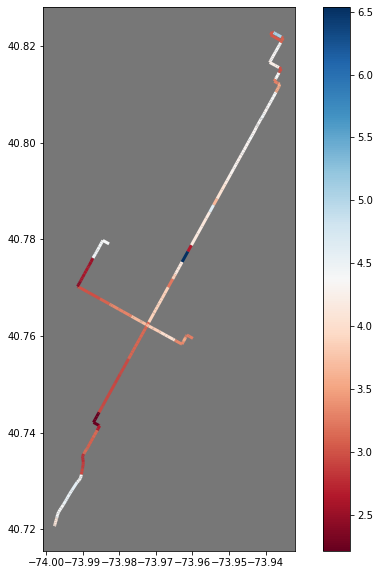

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
speed_edges_gdf.plot(ax=ax, column='speeds_0', cmap='RdBu', zorder=2, linewidth=3, legend=True)
ax.set_facecolor('#777')

In [19]:
trip_mg = speed_mg
nx.set_edge_attributes(trip_mg, all_trip_attr_dict)
trip_edges_gdf = graph_to_edge_gdf(trip_mg)
trip_edges_gdf = trip_edges_gdf.reset_index()
trip_edges_gdf = trip_edges_gdf.rename(columns={'index': 'edge'})
trip_edges_gdf = trip_edges_gdf.drop(columns=['route_id', 'route_dir', 'speeds_0', 'speeds_1', 'speeds_2', 'geometry', 'length'], errors='ignore')
peek(trip_edges_gdf)

319


,edge,OF_C1-Weekday-036000_M1_102,OF_C1-Weekday-038700_M1_103,OF_C1-Weekday-040200_M1_104,OF_C1-Weekday-041700_M1_105,OF_C1-Weekday-043100_M1_106,OF_C1-Weekday-044600_M1_107,OF_C1-Weekday-046100_M1_108,OF_C1-Weekday-047600_M1_109,OF_C1-Weekday-049000_M1_101,...,MQ_C1-Weekday-101100_M57_465,MQ_C1-Weekday-104100_M57_459,MQ_C1-Weekday-105100_M57_464,MQ_C1-Weekday-107100_M57_461,MQ_C1-Weekday-108100_M57_460,MQ_C1-Weekday-111100_M57_465,MQ_C1-Weekday-117100_M57_461,MQ_C1-Weekday-121100_M57_465,MQ_C1-Weekday-133500_M57_465,MQ_C1-Weekday-142500_M57_465
0,"(-73.98112, 40.75027, -73.98067, 40.7509)",85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(-73.98067, 40.7509, -73.98022, 40.75151)",86.0,86.0,86.0,86.0,86.0,86.0,86.0,86.0,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(-73.97669, 40.76411, -73.97612, 40.76386)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0


In [20]:
ip_edges_gdf = speed_edges_gdf.reset_index()
ip_edges_gdf['length'] = ip_edges_gdf['length'] * (0.11 / 0.000001)
ip_edges_gdf['duration_0'] = ip_edges_gdf['length'] / ip_edges_gdf['speeds_0']
ip_edges_gdf['duration_1'] = ip_edges_gdf['length'] / ip_edges_gdf['speeds_1']
ip_edges_gdf['duration_2'] = ip_edges_gdf['length'] / ip_edges_gdf['speeds_2']
ip_edges_gdf[['duration_0', 'duration_1', 'duration_2']] = ip_edges_gdf[['duration_0', 'duration_1', 'duration_2']].fillna(0)
peek(ip_edges_gdf)

319


,index,route_id,route_dir,speeds_0,speeds_1,speeds_2,geometry,length,duration_0,duration_1,duration_2
0,"(-73.98112, 40.75027, -73.98067, 40.7509)",M4,M4_0,2.909634,2.001864,2.421374,"LINESTRING (-73.98112 40.75027, -73.98067 40.7...",85.163020,29.269320,42.541871,35.171361
1,"(-73.98067, 40.7509, -73.98022, 40.75151)",M4,M4_0,2.909634,2.001864,2.421374,"LINESTRING (-73.98067 40.75090, -73.98022 40.7...",83.382612,28.657419,41.652496,34.436072
2,"(-73.97669, 40.76411, -73.97612, 40.76386)",M57,M57_0,3.666894,1.953036,2.350320,"LINESTRING (-73.97669 40.76411, -73.97612 40.7...",68.465612,18.671280,35.055996,29.130340


In [21]:
edge_manifest = ip_edges_gdf[['index', 'speeds_0', 'speeds_1', 'speeds_2', 'length', 'duration_0', 'duration_1', 'duration_2']]
edge_manifest = edge_manifest.rename(columns={'index': 'edge'})
edge_manifest = edge_manifest.merge(trip_edges_gdf, left_on='edge', right_on='edge', how='left')
peek(edge_manifest.iloc[:, 10:])

319


,OF_C1-Weekday-040200_M1_104,OF_C1-Weekday-041700_M1_105,OF_C1-Weekday-043100_M1_106,OF_C1-Weekday-044600_M1_107,OF_C1-Weekday-046100_M1_108,OF_C1-Weekday-047600_M1_109,OF_C1-Weekday-049000_M1_101,OF_C1-Weekday-051000_M1_111,OF_C1-Weekday-052700_M1_112,OF_C1-Weekday-053400_M1_113,...,MQ_C1-Weekday-101100_M57_465,MQ_C1-Weekday-104100_M57_459,MQ_C1-Weekday-105100_M57_464,MQ_C1-Weekday-107100_M57_461,MQ_C1-Weekday-108100_M57_460,MQ_C1-Weekday-111100_M57_465,MQ_C1-Weekday-117100_M57_461,MQ_C1-Weekday-121100_M57_465,MQ_C1-Weekday-133500_M57_465,MQ_C1-Weekday-142500_M57_465
0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86.0,86.0,86.0,86.0,86.0,86.0,86.0,86.0,86.0,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0


In [22]:
def get_start_node(edge):
    return edge[0:2]
def get_end_node(edge):
    return edge[2:]

In [23]:
node_edge_manifest = edge_manifest[['edge']]
node_edge_manifest['start'] = node_edge_manifest['edge'].apply(lambda x: get_start_node(x))
node_edge_manifest['end'] = node_edge_manifest['edge'].apply(lambda x: get_end_node(x))

start_nodes = list(set(node_edge_manifest['start']))
end_nodes = list(set(node_edge_manifest['end']))
nodes = list(set(start_nodes + end_nodes))
node_manifest = pd.DataFrame(nodes)
node_manifest['node'] = node_manifest.apply(lambda x: (x[0], x[1]), axis=1)
node_manifest = node_manifest[['node']]

node_edge_manifest['start'] = node_edge_manifest['start'].apply(lambda x: nodes.index(x))
node_edge_manifest['end'] = node_edge_manifest['end'].apply(lambda x: nodes.index(x))
node_edge_manifest = node_edge_manifest[['start', 'end']]

In [24]:
node_latlon_df = pd.DataFrame(nodes, columns=['lon', 'lat'])
ip_nodes_gdf = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(node_latlon_df['lon'], node_latlon_df['lat']), crs=CRS_LATLON)

In [25]:
def get_prev_edges(row, manifest):
    start = row['start']
    prev_edges = list(manifest[manifest['end'] == start].index)
    return prev_edges

In [26]:
def get_next_edges(row, manifest):
    end = row['end']
    next_edges = list(manifest[manifest['start'] == end].index)
    return next_edges

In [27]:
edge_node_manifest = node_edge_manifest.reset_index().rename(columns={'index': 'edge'})
edge_node_manifest['prev'] = [[] for i in range(len(edge_node_manifest))]
edge_node_manifest['next'] = [[] for i in range(len(edge_node_manifest))]
edge_node_manifest['prev'] = edge_node_manifest.apply(lambda x: get_prev_edges(x, edge_node_manifest), axis=1)
edge_node_manifest['next'] = edge_node_manifest.apply(lambda x: get_next_edges(x, edge_node_manifest), axis=1)
peek(edge_node_manifest)

319


,edge,start,end,prev,next
0,0,271,272,[83],[1]
1,1,272,267,[0],[301]
2,2,0,81,[22],[138]


In [28]:
prev_edges = list(edge_node_manifest['prev'])
next_edges = list(edge_node_manifest['next'])
start_nodes = list(edge_node_manifest['start'])

In [29]:
def get_trip_df(trip_id):
    trip_df = edge_manifest[[trip_id]]
    trip_df = trip_df.dropna()
    trip_df = trip_df.sort_values(by=[trip_id])
    return trip_df

In [30]:
import gurobipy as gp
from gurobipy import GRB

In [31]:
N_EDGES = len(edge_manifest)
N_NODES = len(node_manifest)
EDGE_COST_CABLE = 1 
EDGE_POWER_SUPPLY = 1
EDGE_POWER_DEMAND = 1.25
NODE_TRANSMITTER_COST = 1000

In [32]:
cable_costs = list(ip_edges_gdf['length'] * EDGE_COST_CABLE)
edge_power_supplies = [list(ip_edges_gdf[f'duration_{h}'] * EDGE_POWER_SUPPLY) for h in range(3)]
edge_power_demands = [list(ip_edges_gdf[f'duration_{h}'] * EDGE_POWER_DEMAND) for h in range(3)]
power_costs = [1.68, 23.84, 23.84]

In [33]:
def hash_trip(trip):
    return ','.join([str(x) for x in trip])

In [34]:
trip_ids = list(edge_manifest.columns[10:])
trip_ids
trips = []
trip_hashes = set([])

for trip_id in trip_ids:
    trip_df = get_trip_df(trip_id)
    trip = list(trip_df.index)
    trip_hash = hash_trip(trip)
    if trip_hash not in trip_hashes:
        trips.append(trip)
        trip_hashes.add(trip_hash)
len(trips)

2

In [35]:
HOURS = 1

In [36]:
model = gp.Model('example')

x = model.addVars(N_EDGES, vtype=GRB.BINARY)
y = model.addVars(N_NODES, vtype=GRB.BINARY)
z = model.addVars(len(trips), vtype=GRB.BINARY)

for k, trip in enumerate(trips):
    for h in range(3):
        power = np.sum([edge_power_supplies[h][i] for i in trip])
        battery = power * 0.8
        BATTERY_MAX = battery
        BATTERY_MIN = power * 0.05

        for j in range(1, len(trip)):
            net_power = gp.quicksum(-edge_power_demands[h][i] + x[i] * edge_power_supplies[h][i] for i in trip[0:j])
            model.addConstr(battery + net_power * z[k] >= BATTERY_MIN)
            model.addConstr(battery + net_power * z[k] <= BATTERY_MAX)

        for j in trip:
            transmitter = y[start_nodes[j]]
            prev_cable = gp.quicksum(x[i] for i in prev_edges[j])
            model.addConstr(x[j] <= transmitter + prev_cable)

model.addConstr(gp.quicksum(y[start_nodes[i]] * x[i] for i in range(N_EDGES)) == y.sum())
model.addConstr(z.sum() >= len(trips))

cable_cost = gp.quicksum((x[i] * cable_costs[i]) for i in range(N_EDGES))
transmitter_cost = gp.quicksum((y[i] * NODE_TRANSMITTER_COST) for i in range(N_NODES))
power_cost = gp.quicksum(edge_power_supplies[h][i] * x[i] * power_costs[h] for h in range(3) for i in range(N_EDGES))

objective = cable_cost + transmitter_cost + power_cost
model.setObjective(objective, GRB.MINIMIZE)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-02-01


In [37]:
model.update()
model.Params.MIPGap = 0.05
model.optimize()
print(model.ObjVal)

Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 958 rows, 641 columns and 2873 nonzeros
Model fingerprint: 0x5d16f2f2
Model has 1903 quadratic constraints
Variable types: 0 continuous, 641 integer (641 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [7e-01, 1e+02]
  QLMatrix range   [1e+00, 7e+03]
  Objective range  [5e+01, 6e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
  QRHS range       [1e+03, 4e+03]
Sparsify removed 61490 nonzeros (93%)
Presolve added 0 rows and 44 columns
Presolve removed 232 rows and 0 columns
Presolve time: 0.08s
Presolved: 1684 rows, 1004 columns, 7223 nonzeros
Variable types: 46 continuous, 958 integer (958 binary)
Found heuristic solution: objective 210817.69773

Root relaxation: objective 1.858427e+05, 682 iterations, 0.01 seconds (0.02 work units)

    N

In [38]:
opt_x = model.getAttr('X', model.getVars()[:N_EDGES])
xdf = pd.DataFrame(opt_x, columns=['x'])
len(xdf[xdf['x'] > 0])

153

In [39]:
opt_y = model.getAttr('X', model.getVars()[N_EDGES:N_EDGES+N_NODES])
ydf = pd.DataFrame(opt_y, columns=['y'])
len(ydf[ydf['y'] > 0])

3

In [40]:
def plot_results(xdf, ydf):
    fig, ax = plt.subplots(figsize=(15, 15))
    
    mxdf = ip_edges_gdf.merge(xdf, left_index=True, right_index=True, how='left')
    mxdf.plot(ax=ax, column='x', cmap='Blues', zorder=2, linewidth=3, legend=True)
    
    mydf = ip_nodes_gdf.merge(ydf, left_index=True, right_index=True, how='left')
    mydf = mydf[mydf['y'] == 1]
    mydf.plot(ax=ax, color='C1', zorder=3, markersize=30)
    
    ax.set_facecolor('#777')

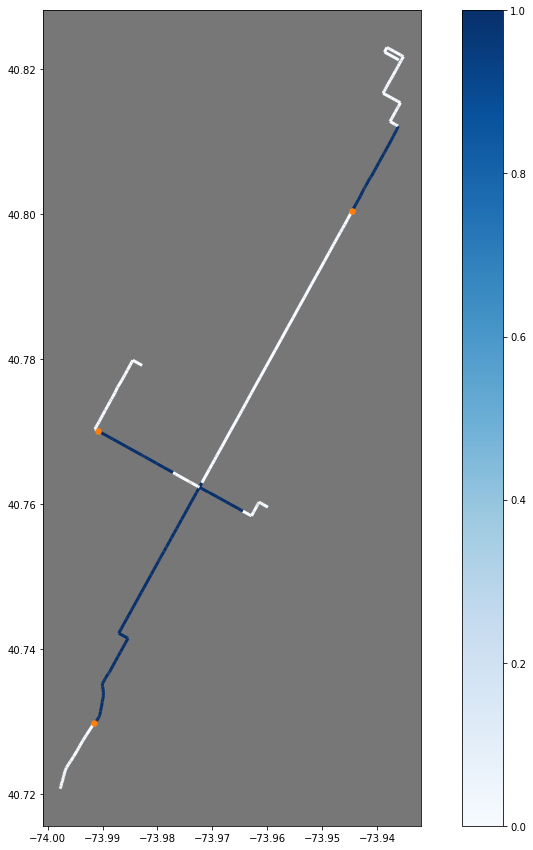

In [41]:
plot_results(xdf, ydf)